In [1]:
## Basic python imports and model settings

import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

# import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os
import sys

import time

from scipy.signal import savgol_filter

# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]

# make it command line compatible
if len(sys.argv):
    try:
        km_index = int(sys.argv[1])
    except:
        km_index = 5

i = km_index

maxX = L[i] * 1000.
min_bed_height = 0.           # we want a minimum of 500 m of rock beneath the ice
omega = 2.0 * np.pi / maxX
amplitude = 500.
average_bedheight = 1000.
maxY = average_bedheight + amplitude

minY = minX = 0.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.

resX = 250
resY = 100

resX = 25
resY = 10

print("resX: " + str(resX) + " resY: " + str(resY))

# generate output path
if not os.getcwd().endswith("output"):
    outputPath = os.path.join(os.path.abspath("."), "output")

    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

    os.chdir(outputPath)

delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 6

number_of_deformation_points = 50000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)

cell_height = maxY / resY
cell_width = maxX / resX

viz_opts = {
                "figsize"     : (2000,400),
                "edgecolour"   :  "black",
                "quality"      :  3,          # antialiasing
                "align"        : "bottom",     # colour bar alignment
                #"size"        : (0.83,0.01), # colour bar size
                #"position"    : 0.,          # colour bar position
                #"boundingBox"  : ((minX, maxX), (minY, maxY), (minZ, maxZ)),
                "axis"         : True,
                "scale"        : True,
           }

resX: 25 resY: 10


In [2]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(minX, minY),
                                maxCoord=(maxX, maxY),
                                periodic=[True, False])

submesh = mesh.subMesh


	Global element size: 25x10
	Local offset of rank 0: 0x0
	Local range of rank 0: 25x10



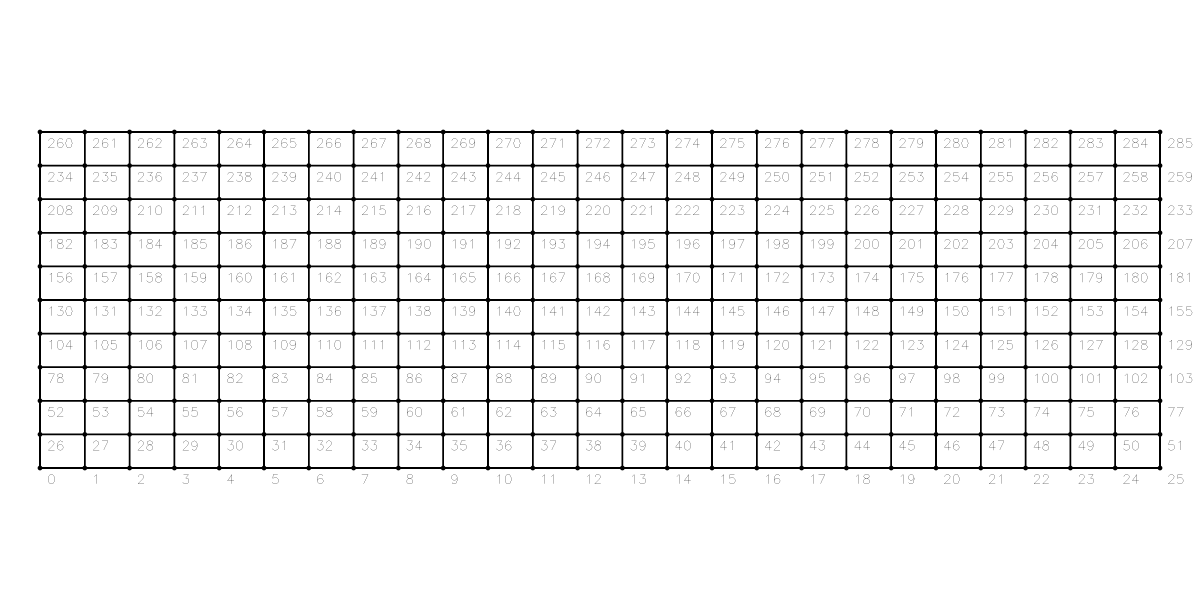

0.986635785864



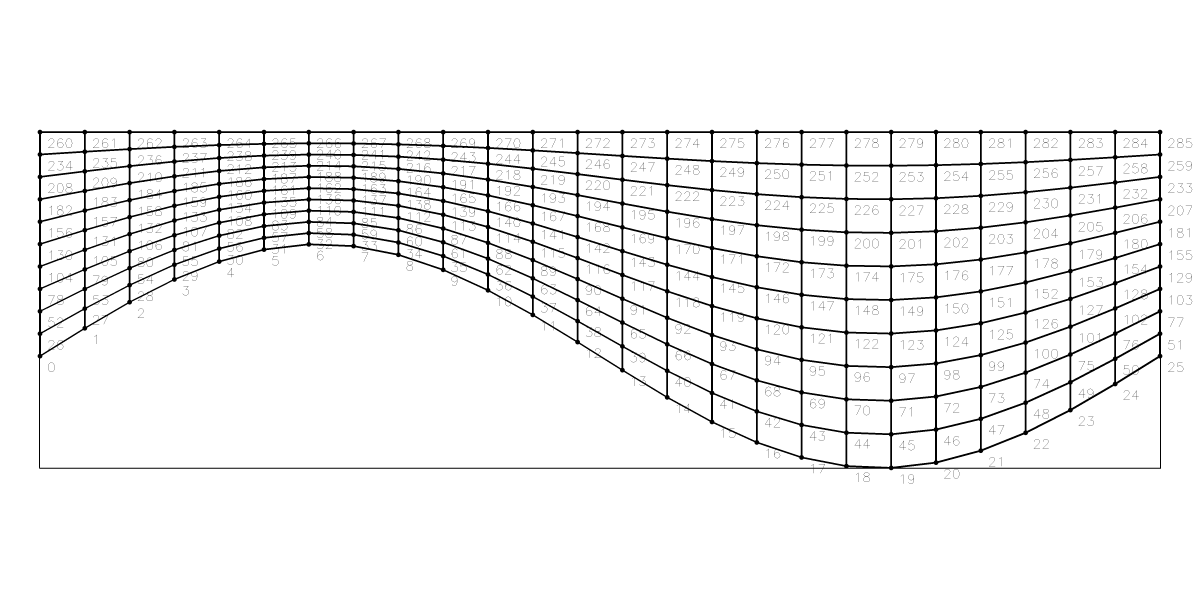

In [3]:
dx = (maxX - minX) / resX
dy = (maxY - minY) / resY

figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh, nodeNumbers=True))
figMesh.show()

''''''

interface_y =  500. + amplitude * np.sin(mesh.data[:, 0] * (np.pi * 2.) / (maxX - minX) )

# testing: use whole mesh at once
with mesh.deform_mesh():

    #mi = 0.25


    mesh.data[:, 1] = mesh.data[:, 1] + interface_y * (maxY - mesh.data[:,1]) / maxY
    
    # zz_pow = (section[index] - fixPoint)**mi
    # zz_pow_max = (maxCoord - fixPoint)**mi
    # section[index] = fixPoint + (section[index]-fixPoint) * zz_pow / zz_pow_max
    
    print(np.min(interface_y))
    #zz_pow_max = (maxCoord - interface_y)**mi
    #mesh.data[:,1] = interface_y + (section[index] - interface_y) * zz_pow / zz_pow_max
 
figMesh.show()

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
vdotv  = fn.math.dot(velocityField,velocityField)

pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock
materialT = 5   # test material in order to test eg interface detection

coord = fn.input()

6
12



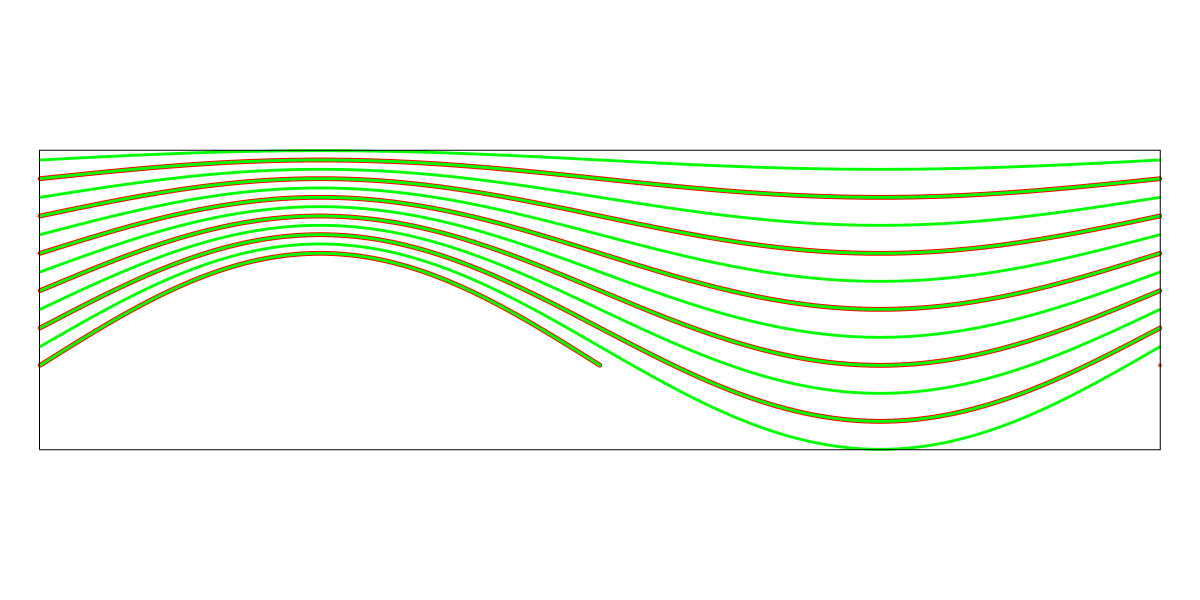

In [4]:
part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm=swarm, particlesPerCell=part_per_cell)
#swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=5 )

swarm.populate_using_layout(layout=swarmLayout)

number_of_deformation_lines = int(number_of_deformation_lines)
print (number_of_deformation_lines)

deformationSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

d_y = maxY / number_of_deformation_lines
x = np.linspace(0., maxX, 20000)

for i in range(0, number_of_deformation_lines):
    
    scaling_factor = (maxY - d_y * i) / maxY    

    interface_y = (500. + amplitude * np.sin(x * (np.pi * 2.) / maxX ) ) * scaling_factor + i * d_y
    
    points = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(interface_y, axis = 1)), axis=1)
    
    deformationSwarm.add_particles_with_coordinates(points)

# double resolution high density deformation swarm
number_of_deformation_lines = int(2 * number_of_deformation_lines)
print (number_of_deformation_lines)

deformationSwarmHD = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

d_y = maxY / number_of_deformation_lines
x = np.linspace(0., maxX, 20000)

for i in range(0, number_of_deformation_lines):
    
    scaling_factor = (maxY - d_y * i) / maxY    

    interface_y = (500. + amplitude * np.sin(x * (np.pi * 2.) / maxX ) ) * scaling_factor + i * d_y
    
    points = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(interface_y, axis = 1)), axis=1)
    
    deformationSwarmHD.add_particles_with_coordinates(points)
    
number_of_deformation_lines = int(number_of_deformation_lines / 2)

''''''

figDefSwarm = vis.Figure(figsize=(1200,600))
#figDefSwarm.append( vis.objects.Mesh(mesh) )
figDefSwarm.append( vis.objects.Points(deformationSwarmHD, colour="green", pointSize=3))
figDefSwarm.append( vis.objects.Points(deformationSwarm, colour='red', pointSize=5))
figDefSwarm.show()
    
defSwarmVar = deformationSwarm.add_variable(dataType="int", count=1)
defSwarmVar.data[:] = 1

defSwarmVarHD = deformationSwarmHD.add_variable(dataType="int", count=1)
defSwarmVarHD.data[:] = 1

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(deformationSwarm)
pop_control3 = uw.swarm.PopulationControl(deformationSwarmHD)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm,velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=deformationSwarm,     velocityField=velocityField, order=2)
advector3 = uw.systems.SwarmAdvector(swarm=deformationSwarmHD,   velocityField=velocityField, order=2)

# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

coord = fn.input()

materialVariable.data[:] = materialV

director =swarm.add_variable(dataType="double", count=2)
director.data [:] = (0.0, 1.0)

cAngle = swarm.add_variable(dataType="double", count=1)
cAngle.data[:] = np.pi / 2.

particleVelocity = swarm.add_variable(dataType="double", count=1)
particleVelocity.data[:] = 0.

particleTemperature = swarm.add_variable(dataType="double", count=1)
particleTemperature.data[:] = 0.

particleStrainrate = swarm.add_variable ( dataType="double", count=1 )
particleStrainrate.data[:] = 0.

particleShearstress = swarm.add_variable ( dataType="double", count=1 )
particleShearstress.data[:] = 0.

particleViscosity = swarm.add_variable ( dataType="double", count=1 )
particleViscosity.data[:] = 0.

In [5]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+10 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e22 / 3.1536e7)

scale_factor_hard_ice_direction = 10.
scale_factor_soft_ice_direction = 10.

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e22 / 3.1536e7)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / float(n)))
viscosityFnIce1 = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn) * scale_factor_hard_ice_direction
viscosityFnIce2 = viscosityFnIce1 * (1. - 1./scale_factor_soft_ice_direction)

viscosityMap1 = {
                materialV: viscosityFnIce1,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock,
               }

viscosityMap2 = {
                materialV: viscosityFnIce2,
                materialA: 0.,
                materialR: 0.,
               }

viscosityFn1 = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap1 )
viscosityFn2 = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap2 )

logViscosityFn = fn.math.log10( viscosityFnIce1 )

devStressFn = 2.0 * viscosityFn1 * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn1 * 2.0

densityFnAir = fn.misc.constant( 0. )
densityFnIce = fn.misc.constant( ice_density )
densityFnRock = fn.misc.constant( 2700. )

densityMap = {
                materialA: densityFnAir,
                materialV: densityFnIce,
                materialR: densityFnRock
             }

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

particleDensity.data[:] = densityFn.evaluate(swarm)

surf_inclination = 0.5 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))

buoyancyFn = densityFn * z_hat * 9.81

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']

### Dirichlet
velocityField.data[:] = [0., 0.]

cond_dirichlet = uw.conditions.DirichletCondition(variable=velocityField,indexSetsPerDof=(botSet, botSet + topSet))

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=cond_dirichlet,
    fn_viscosity=viscosityFn1,
    _fn_viscosity2=viscosityFn2,
    _fn_director=director,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

solver.set_inner_method("mumps")
# nl_tol = 2.e1
nl_tol = 5.e-3

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=topSet)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=topSet)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    # solver.solve(nonLinearIterate=True)
            
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)

In func WeightsCalculator_CalculateAll(): for swarm "C9SMFFSM__swarm"
Calibration pressure -4997432.143974746
	done 33% (84 cells)...
	done 67% (167 cells)...
	done 100% (250 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "C9SMFFSM__swarm"
In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Linear solver (TCUG0CMX__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0003599 secs / 1 its
  Pressure Solve:         = 0.006828 secs / 29 its
  Final V Solve:          = 0.0002257 secs / 1 its

  Total BSSCR Linear solve time: 0.010202 seconds

Linear solver (TCUG0CMX__system-execute), solution time 1.088373e-02 (secs)
Calibration pressure -4752878.351713654
Non linear solver - iteration 1
Linear solver (TCUG0CMX__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction So

In func SystemLinearEquations_NonLinearExecute: Iteration 11 of 500 - Residual 0.0090243 - Tolerance = 0.01
Non linear solver - Residual 9.02433808e-03; Tolerance 1.0000e-02 - Converged - 4.682289e-01 (secs)

In func SystemLinearEquations_NonLinearExecute: Converged after 11 iterations.

 
Pressure iterations:  27
Velocity iterations:   1 (presolve)      
Velocity iterations:  27 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  29 (total solve)   
 
SCR RHS  setup time: 1.2347e-03
SCR RHS  solve time: 2.4711e-04
Pressure setup time: 6.7498e-05
Pressure solve time: 6.5199e-03
Velocity setup time: 9.0000e-08 (backsolve)
Velocity solve time: 2.3033e-04 (backsolve)
Total solve time   : 8.5477e-03
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 




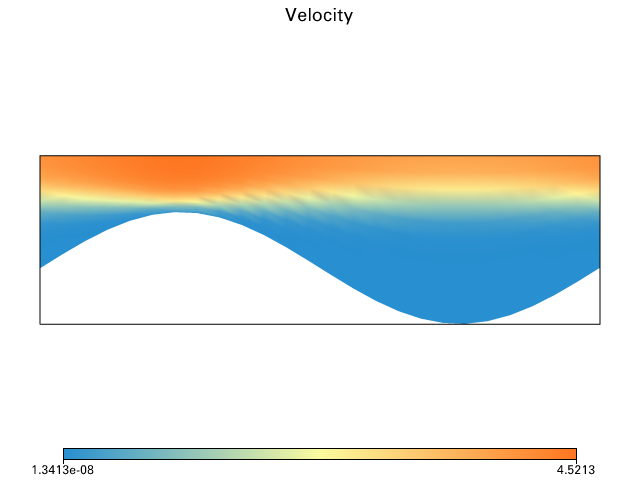

In [6]:
meshShearStress = mesh.add_variable( 1 )
projectorShearStress = uw.utils.MeshVariable_Projection( meshShearStress, shearStressFn, type=0 )
projectorShearStress.solve()

meshVelocity = mesh.add_variable( 1 )
projectorVelocity = uw.utils.MeshVariable_Projection( meshVelocity, vdotv, type=0 )
projectorVelocity.solve()

meshStrainRate = mesh.add_variable( 1 )
projectorStrainRate = uw.utils.MeshVariable_Projection( meshStrainRate, strainRate_2ndInvariantFn, type=0)
projectorStrainRate.solve()

meshViscosity = mesh.add_variable( 1 )
projectorViscosity = uw.utils.MeshVariable_Projection( meshViscosity, viscosityFn1, type=0 )
projectorViscosity.solve()

figVel = vis.Figure( viz_opts, title="Velocity" )
figVel.append( vis.objects.Surface(mesh, meshVelocity) )
#figVel.append( vis.objects.VectorArrows(mesh, velocityField) )
figVel.show()

figStress = vis.Figure( viz_opts, title="Stress" )
figStress.append( vis.objects.Surface(mesh, meshShearStress) )
figStress.show()

figStrainRate = vis.Figure( viz_opts, title="StrainRate" )
figStrainRate.append( vis.objects.Surface(mesh, meshStrainRate) )
figStrainRate.show()

figViscosity = vis.Figure( viz_opts, title="Viscosity" )
figViscosity.append( vis.objects.Surface(mesh, meshViscosity ) )
figViscosity.show()

In [7]:
def c_axis_rotation(dt):

    iceIndices = np.array(np.where(materialVariable.data == materialV)[0])

    velGrad = velocityField.fn_gradient.evaluate(swarm).reshape(
        swarm.particleLocalCount, 2, 2)
    velGrad = velGrad[iceIndices]
    velGradT = velGrad.swapaxes(-1, 1)

    # rate of deformation and rate of rotation
    D = 0.5 * (velGrad + velGradT)
    W = 0.5 * (velGrad - velGradT)

    director.data[iceIndices] = director.data[iceIndices] + dt * (
        np.einsum("ijk,ik->ij", W, director.data[iceIndices]) -
        np.einsum("ijk,ik->ij", D, director.data[iceIndices]) + np.einsum(
            "ij,ij->i", director.data[iceIndices],
            np.einsum("ijk,ik->ij", D, director.data[iceIndices]))[:, None] *
        director.data[iceIndices])

    # finally normalize the c-axes
    director.data[iceIndices] = director.data[iceIndices] / np.absolute(
        np.linalg.norm(director.data[iceIndices], axis=1).reshape(
            len(iceIndices), 1))

def calc_caxes_angles():

    global director
    global cAngle

    director.data[np.where(director.data[:, 1] < 0.),
                  0] = -director.data[np.where(director.data[:, 1] < 0.), 0]
    
    director.data[np.where(director.data[:, 1] < 0.),
                  1] = -director.data[np.where(director.data[:, 1] < 0.), 1]
    
    cAngle.data[:, 0] = np.arctan2(director.data[:, 1], director.data[:, 0])

    cAngle.data[np.where(cAngle.data[:] > np.pi), 0] = np.pi / 2.
    
    
def update_infinite_flow(t):
    """
    In order for infinite flow to work you need to
    a) use the same medication as MC Escher,
    b)  1) generate 'inclination' --> z_hat definition
        2) activate wrapping by setting 'periodic = [True, False]' during the mesh creation
    """

    global meshV, maxX, maxY, snowfall_rate, nl_tol
    global calibrate_pressure

    # we are first trying to base the flow law on years
    #t *= 365. * 86400.

    tin = t

    while t:

        solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)

        # Retrieve the maximum possible timestep for the advection system.
        dt = min([
            advector1.get_max_dt(),
            advector2.get_max_dt(),
            advector3.get_max_dt(),
        ])

        print(f'---------------------{dt}')
        # exit(0)

        if dt > t:
            dt = t
            t = 0.
        else:
            t = t - dt

        #print(t)

        # Advect using this timestep size.
        advector1.integrate(dt)  # the swarm
        advector2.integrate(dt)  # sedimentary layers
        advector3.integrate(dt)  # sedimentary layers with double density

        # particle population control
        # not sure, if this is really necessary. it is _not_ in the standard advecton code, but only if there is a mesh-deformation involved. my hope would be that this command will not allow underresolved cells
        pop_control1.repopulate()
        # pop_control2.repopulate()
        # pop_control3.repopulate()

        print (f'Time left in infinite flow loop: {t}')

        #for i in range (100):
            #c_axis_rotation(dt / 100.)

    return (tin)

In [8]:
def main():

    # Stepping. Initialise time and timestep.

    time = 0.
    step = 0
    nsteps = 11
    delta_timestep = 1. # given in years, converted to s in the flow function
    output_step = 5
    
    xdmf_mesh = mesh.save('mesh.h5')
    
    while step < nsteps:

        update_infinite_flow(t = delta_timestep)
        calc_caxes_angles()

        time = step * delta_timestep

        if not step % output_step:

            ignore = swarm.save('swarm_' + str(step).zfill(5) + '.h5')

            # meshShearStress = mesh.add_variable( 1 )
            # meshVelocity = mesh.add_variable( 1 )
            # meshStrainRate = mesh.add_variable( 1 )
            # meshViscosity = mesh.add_variable( 1 )
            projectorShearStress.solve()
            projectorVelocity.solve()
            projectorStrainRate.solve()
            projectorViscosity.solve()
            
            # eval swarm variables non-projected
            # particleStrainrate.data[:] = strainRate_2ndInvariantFn.evaluate(swarm)
            # particleViscosity.data[:] = viscosityFn1.evaluate(swarm)
            # particleVelocity.data[:] = np.sqrt(vdotv.evaluate(swarm))
            # particleShearstress.data[:] = meshShearStress.evaluate(swarm)

            # eval swarm variables projected
            particleStrainrate.data[:] = meshStrainRate.evaluate(swarm)
            particleViscosity.data[:] = meshViscosity.evaluate(swarm)
            particleVelocity.data[:] = meshVelocity.evaluate(swarm)
            particleShearstress.data[:] = meshShearStress.evaluate(swarm)
            
            # save swarm variables as xdmf files
            xdmf_swarm = swarm.save('swarm_' + str(step).zfill(5) + '.h5')
            xdmf_defSwarm = deformationSwarm.save('defSwarm_' + str(step).zfill(5) + '.h5')
            xdmf_defSwarmHD = deformationSwarmHD.save('defSwarmHD_' + str(step).zfill(5) + '.h5')

            xdmf_defSwarmVar = defSwarmVar.save('defSwarmVar_' + str(step).zfill(5) + '.h5')
            defSwarmVar.xdmf('def_SwarmVar_' + str(step).zfill(5) + '.xdmf', xdmf_defSwarmVar, "defSwarmVar", xdmf_defSwarm, "deformationSwarm", modeltime=step)

            xdmf_defSwarmVar = defSwarmVar.save('defSwarmVar_' + str(step).zfill(5) + '.h5')
            defSwarmVar.xdmf('def_SwarmVar_' + str(step).zfill(5) + '.xdmf', xdmf_defSwarmVar, "defSwarmVar", xdmf_defSwarm, "deformationSwarm", modeltime=step)

            xdmf_defSwarmVarHD = defSwarmVarHD.save('defSwarmVarHD_' + str(step).zfill(5) + '.h5')
            defSwarmVarHD.xdmf('def_SwarmVarHD_' + str(step).zfill(5) + '.xdmf', xdmf_defSwarmVarHD, "defSwarmVarHD", xdmf_defSwarmHD, "deformationSwarm", modeltime=step)
            
            xdmf_particleShearstress = particleShearstress.save('particleShearstress_' + str(step).zfill(5) + '.h5')
            particleShearstress.xdmf('particleShearstress_' + str(step).zfill(5) + '.xdmf', xdmf_particleShearstress, "particleShearstress", xdmf_swarm, "Swarm", modeltime=step)

            xdmf_particleStrainrate = particleStrainrate.save('particleStrainrate_' + str(step).zfill(5) + '.h5')
            particleStrainrate.xdmf('particleStrainrate_' + str(step).zfill(5) + '.xdmf', xdmf_particleStrainrate, "particleStrainrate", xdmf_swarm, "Swarm", modeltime=step)

            xdmf_Director = director.save('director_' + str(step).zfill(5) + '.h5')
            director.xdmf('director_' + str(step).zfill(5) + '.xdmf', xdmf_Director, "Director", xdmf_swarm, "Swarm", modeltime=step)

            xdmf_particleViscosity = particleViscosity.save('particleViscosity_' + str(step).zfill(5) + '.h5')
            particleViscosity.xdmf('particleViscosity_' + str(step).zfill(5) + '.xdmf', xdmf_particleViscosity, 'particleViscosity', xdmf_swarm, 'Swarm', modeltime=step)

            xdmf_particleCAngle = cAngle.save('cAngle_' + str(step).zfill(5) + '.h5')
            cAngle.xdmf('cAngle_' + str(step).zfill(5) + '.xdmf', xdmf_particleCAngle, 'cAngle', xdmf_swarm, 'Swarm', modeltime=step)

            # visualizing the velocityField in paraviewe doesn't work for whatever reason (Paraview just crashes)
            # so we save it as a particle property
            xdmf_particleVelocity = particleVelocity.save('particleVelocity_' + str(step).zfill(5) + '.h5')
            particleVelocity.xdmf('particleVelocity_' + str(step).zfill(5) + '.xdmf', xdmf_particleVelocity, "particleVelocity", xdmf_swarm, "Swarm", modeltime=step)


            xdmf_particleTemp = particleTemperature.save('particleTemperature_' + str(step).zfill(5) + '.h5')
            particleTemperature.xdmf('particleTemperature_' + str(step).zfill(5) + '.xdmf', xdmf_particleTemp, "particleTemperature", xdmf_swarm, "Swarm", modeltime=step)

            xdmf_particleDensity = particleDensity.save('particleDensity_' + str(step).zfill(5) + '.h5')
            particleDensity.xdmf('particleDensity_' + str(step).zfill(5) + '.xdmf', xdmf_particleDensity, "particleDensity", xdmf_swarm, "Swarm", modeltime=step)

        step += 1

        print()
        print('--------------------')
        print(str(time) + ' years, step: ' + str(step))
        print('--------------------')
        print()
            
        print(f'Finished timestep: {step}')

if __name__ == "__main__":
    main()

In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Calibration pressure -4382859.066057416
Calibration pressure -4381526.729427847
---------------------11.623108068026921
Linear solver (V07EMO33__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0002582 secs / 1 its
  Pressure Solve:         = 0.006295 secs / 27 its
  Final V Solve:          = 0.0002349 secs / 1 its

  Total BSSCR Linear solve time: 0.008046 seconds

Linear solver (V07EMO33__system-execute), solution time 8.159679e-03 (secs)
Non linear solver - iteration 1
Linear solver (V07EMO33__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0002437 secs / 1 its
  Pressure Solve:         = 0.006

Time Integration
	2nd order:                 IMF5DOCF__integrand -    0.1333 [min] /    0.1333 [max] (secs)
Time Integration - 0.133337 [min] / 0.133337 [max] (secs)
Time left in infinite flow loop: 0.0
In func WeightsCalculator_CalculateAll(): for swarm "YJY4WDI8__swarm"
	done 33% (84 cells)...
	done 67% (167 cells)...
	done 100% (250 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "YJY4WDI8__swarm"

--------------------
3.0 years, step: 4
--------------------

Finished timestep: 4
In func WeightsCalculator_CalculateAll(): for swarm "YJY4WDI8__swarm"
	done 33% (84 cells)...
	done 67% (167 cells)...
	done 100% (250 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "YJY4WDI8__swarm"
In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Linear solver (V07EMO33__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_p

Time Integration
	2nd order:                 XCLMI7YB__integrand -    0.0861 [min] /    0.0861 [max] (secs)
Time Integration - 0.0861317 [min] / 0.0861317 [max] (secs)
Time left in infinite flow loop: 0.0
Time Integration
	2nd order:                 IMF5DOCF__integrand -    0.1337 [min] /    0.1337 [max] (secs)
Time Integration - 0.133739 [min] / 0.133739 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "YJY4WDI8__swarm"
	done 33% (84 cells)...
	done 67% (167 cells)...
	done 100% (250 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "YJY4WDI8__swarm"

--------------------
7.0 years, step: 8
--------------------

Finished timestep: 8
In func WeightsCalculator_CalculateAll(): for swarm "YJY4WDI8__swarm"
	done 33% (84 cells)...
	done 67% (167 cells)...
	done 100% (250 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "YJY4WDI8__swarm"
In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Li